# Deep Bucket Lab: 
## A playground for understanding hydrologic process representations with Deep Learning

This notebook is designed to help students understand the fundamentals of simulating dynamic systems with Deep Learning. 


The tutorial models a leaking bucket, a much simpler hydrological system than a watershed, allowing us to easily evaluate whether our leaking bucket models approximante expected physical processes.

We generate all data synthetically in this notebook using simple numerical simulations of the hydrological system (leaking buckets) and varying bucket characteristics/attributes and variables including dynamic forcings for precipitation. 

We develop a single-layer Long Short-Term Memory (LSTM) network to learn dynamics of water level and fluxes out from bucket based on the "ground truth" data.

In this notebook, the user can experiment with modifying the bucket model attributes and modelling setup to explore hydrologic process representations and their predictability.

# 1. Setup

The first thing to do is setup the notebook environment with all the libraries, declare model global parameters, settings, variables and functions that define the bucket system we want to represent, as well as define the hyperparameters and structure for the deep learning model. 

Note: in a typical full-scale modeling framework, these would be decalared in a configuration file.

### 1.1 Importing libraries 

We import standard libraries for data management, calculations and plotting. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

We import machine learning libraries for modeling architectures, training, validation and testing.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable 
import sklearn
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange, tqdm

### 1.2 Defining the physical bucket model system

**Global variables**

Constants in our bucket model system are:
- g, gravitational acceleration [$m/s^2$]
- time step [$s$]

In [3]:
g = 9.807
time_step = 1

**Parameters for the Forcing Process (Precipitation)**

To generate precipitation data for our hydrological system, we employ a simple random process that determines whether it is raining based on the previous state, as well as the total amount of rain during the event.

We classify precipitation into three types: None, Light, and Heavy. Each type has distinct ranges of rainfall probabilities and depths.

In [4]:
rain_probability_range = {"None": [0.6, 0.7], 
                          "Light": [0.5, 0.8], 
                          "Heavy": [0.2, 0.3]}

rain_depth_range = {"Light": [0, 2], "Heavy": [2, 8]}

**Bucket physical attributes**

The physical leaky bucket attributes include:
- A_bucket, bucket area [$m^2$]
- A_spigot, spigot areas [$m^2$]
- H_bucket, bucket heights [$m$]
- H_spigot, spigot heights [$m$]
- K_infiltration, infiltration rate [$mm/hr$]
- ET_parameter, evapotranspiration parameter [$mm/day$]

We will generate a diversity of leaky buckets by randomy selecting their physical attribute values from the following possible ranges.

In [5]:
bucket_attributes_range = {"A_bucket": [1.0, 2.0],
                           "A_spigot": [0.1, 0.2],
                           "H_bucket": [5.0, 6.0],
                           "H_spigot": [1.0, 3.0],
                           "K_infiltration": [1e-7, 1e-9],
                           "ET_parameter": [7, 9]
                          }

bucket_attributes_list = list(bucket_attributes_range.keys())

**Channel physical parameters**

This section includes the channel physical parameters. Initially, the transformation parameters are defined

- transform_type: 0 (null transform), 1 (simple shift), 2 (time-based displacement), 3 (simple attenuation), 4 (LagK), 5 (Muskingum-Cunge)
- shift_amount: position number to shift (applies when transform_type == 1)
- time_shift: specified number of seconds to move the streamflow
- attenuation_factor: value for multiplying the streamflow
- lag_amount: number of streamflow positions to delay the output
- param_list: list of parameters to apply Muskingum-Cunge transformation


In [6]:
transform_params_range = {"transform_type": [0], #"transform_type": [0, 1, 3, 4], #transform_types 2 and 5 are not currently implemented
                          "shift_amount": [0, 100],
                          # "time_shift": [],
                          "attenuation_factor": [0.01, 0.99],
                          "lag_amount": [0, 100]
                         }

transform_params_list = list(transform_params_range.keys())

**Model input and output variables**

The data fluxes in and out of the leaky bucket considered in this stystem and the leaky bucket state, include
- precipitation into the bucket as a model input (precip) 
- the actual and potential loss to evaporation from the bucket as model inputs (et, pet)
- the water flow over the bucket and out of the spigot as a simulated model output(q_overflow, q_spigot)
- and the state of the water head in the bucket as a simluated model output (h_bucket).

We define lists based on these input and output leaking bucket model variables.

n_input is the number of features to use in the LSTM model. This number will be determined by n_buckets_per_network * number of bucket attributes + 2 (q_overflow_output + q_spigot_output)
n_output is the number of features to predict per number of buckets per network. (Not sure yet about this. We need to review)

In [7]:
n_buckets_per_network = 3
input_vars = ['precip', 'et', 'q_total_output']
input_vars.extend(bucket_attributes_list)
output_vars = [['q_overflow', 'q_spigot'] for _ in range(n_buckets_per_network)] 
#n_input = (n_buckets_per_network * (len(input_vars) - 2)) + 2
#n_output = len(output_vars[0]) * n_buckets_per_network
n_input = len(input_vars)
n_output = len(output_vars[0])

**Data noise**

Because real world systems are noisy, we can add noise to the synthetic data by multiplying the values by a random factor taken from a normal distribution with a mean of 1 and a standard deviation prescribed for different variables.

In [8]:
print(n_input, n_output, bucket_attributes_list)
is_noise = True
noise = {"pet": 0.1, "et": 0.1, "q": 0.1, "head": 0.1} 

9 2 ['A_bucket', 'A_spigot', 'H_bucket', 'H_spigot', 'K_infiltration', 'ET_parameter']


Illustration of leaking bucket hydrological system


![title](figs/bucket_schematic.png)

### 1.3 Defining the modeling setup 

**Deep Learning Model (LSTM) Hyperparameters**

The hyperparameters for the LSTM (Long Short-Term Memory) deep learning model include:
- device: The device (CPU or CUDA) used for training and inference.
- hidden_state_size: The number of units in the hidden state of the LSTM model.
- num_layers: Number of LSTM layers.
- num_epochs: Number of training epochs.
- batch_size: Number of samples in each training batch.
- seq_length: Length of input sequences.
- learning_rate: Learning rate for the optimizer.
- num_classes: Number of output classes.
- input_size: Size of the input layer.

These hyperparameters control the behavior and performance of the LSTM model and can be adjusted to optimize the model's accuracy and generalization capabilities for specific tasks and datasets.

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'

hidden_state_size = 16
num_layers = 8
num_epochs = 15  
batch_size = 256 
seq_length = 24
learning_rate = np.linspace(start=0.1, stop=0.01, num=num_epochs)
'''
hidden_state_size = 160
num_layers = 80
num_epochs = 150  
batch_size = 256 
seq_length = 24
learning_rate = np.linspace(start=0.1, stop=0.01, num=num_epochs)
'''

'\nhidden_state_size = 160\nnum_layers = 80\nnum_epochs = 150  \nbatch_size = 256 \nseq_length = 24\nlearning_rate = np.linspace(start=0.1, stop=0.01, num=num_epochs)\n'

**Size of data records and splits**

The deep learning framework requires the data to be split into 3 different sets
- Back propogation is done on the training set (train)
- Hyperparameter tuning is done on the validation set (val)
- Calculating model accuracy is done on the testing set (test)

We will define how many randomly generated bucket configurations to use for the "train", "val", and "test" sets, as well as the length of the simulations for each set.

For example, if we have a training set with 10 different buckets, the "split" refers to dividing the data into multiple bucket configurations. In this case, it means that we will train the model using 10 randomly generated bucket configurations.

Furthermore, if we have 1000 time steps for each bucket, the "time split" indicates the number of time steps we will use for training the model. In this scenario, we will train the model using 1000 time steps for each of the 10 bucket configurations.

**For creating a basin network**

We will define three basin network sets for the use of "train", "val", and "test". Additionally it is necessary to define the number of buckets in every basin network (n_bucket_per_network). Consequently, the number of buckets is equal to the number of basin networks multiplied by the number of buckets per network.

In [10]:
#n_buckets_split = {"train": 10, "val": 5,"test": 1}
time_splits = {"train": 1000, "val": 500,"test": 500}
#time_splits = {"train": 5000, "val": 2500,"test": 2500}

n_basin_networks_split = {"train": 15, "val": 7, "test": 2}
#n_basin_networks_split = {"train": 300, "val": 100, "test": 20}
n_buckets_split = {"train": n_basin_networks_split["train"] * n_buckets_per_network, "val": n_basin_networks_split["val"] * n_buckets_per_network,"test": n_basin_networks_split["test"] * n_buckets_per_network}

We use the settings above to calculate the total length of the data record to generate and the total number of buckets and basin networks

In [11]:
num_records = time_splits["train"] + time_splits["val"] + time_splits["test"] + seq_length * 3
n_buckets = n_buckets_split["train"] + n_buckets_split["val"] + n_buckets_split["test"]
n_basin_networks = n_basin_networks_split["train"] + n_basin_networks_split["val"] + n_basin_networks_split["test"]
print(n_basin_networks)

24


We then calculate the parameters for the bucket and time splits necessary to feed the model with separate datasets for training, validation, and testing.

We need to create a new function to calculate parameter for the basin network splits into separate datasets.

In [12]:
def split_parameters():
    # create lists of bucket indices for each set based on the given bucket splits
    buckets_for_training = list(range(0, n_buckets_split['train'] + 1))
    buckets_for_val = list(range(n_buckets_split['train'] + 1, 
                                 n_buckets_split['train'] + n_buckets_split['val'] + 1))
    buckets_for_test = list(range(n_buckets - n_buckets_split['test'], n_buckets))

    # determine the time range for each set based on the given time splits
    train_start = seq_length
    train_end   = time_splits["train"]
    val_start   = train_end + seq_length
    val_end     = val_start + time_splits["val"]
    test_start  = val_end + seq_length
    test_end    = test_start + time_splits["test"]
    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [buckets_for_training, train_start, train_end]
    val_split_parameters = [buckets_for_val, val_start, val_end]
    test_split_parameters = [buckets_for_test, test_start, test_end]
    
    return [train_split_parameters, val_split_parameters, test_split_parameters]

In [13]:
[[buckets_for_training, train_start, train_end],
[buckets_for_val, val_start, val_end],
[buckets_for_test, test_start, test_end]]= split_parameters()
print([[buckets_for_training, train_start, train_end],
[buckets_for_val, val_start, val_end],
[buckets_for_test, test_start, test_end]])

[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], 24, 1000], [[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66], 1024, 1524], [[66, 67, 68, 69, 70, 71], 1548, 2048]]


This function will create separate datasets for training, validation, and testing.

In [14]:
def basin_split_param():
    #create lists of basin indices for each set
    basins_train = list(range(0, n_basin_networks_split['train']))
    basins_val = list(range(n_basin_networks_split['train'], 
                            n_basin_networks_split['train'] + n_basin_networks_split['val']))
    basins_test = list(range(n_basin_networks - n_basin_networks_split['test'], n_basin_networks)) 
    
    #place basin split parameters into separate lists
    train_basin_split_param = [basins_train]
    val_basin_split_param = [basins_val]
    test_basin_split_param = [basins_test]
    
    #determine transform parameters per basin network
    
    
    return [train_basin_split_param, val_basin_split_param, test_basin_split_param]

This will run the function above and print out the range for the whole basin network split

In [15]:
[[basin_networks_train],[basin_networks_val],[basin_networks_test]]= basin_split_param()
print([[basin_networks_train],[basin_networks_val],[basin_networks_test]])

[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]], [[15, 16, 17, 18, 19, 20, 21]], [[22, 23]]]


### 1.4 Creating a sample of diverse buckets

Now that we know how many buckets we want, we can generate a sample of diverse buckets with their respective boundary and initial conditions by randomly sampling from the possible ranges for each attribute defined in the settings above.

In [16]:
def setup_buckets(n_buckets):
    # Boundary conditions
    buckets = {bucket_attribute:[] for bucket_attribute in bucket_attributes_list}
    for i in range(n_buckets):
        for attribute in bucket_attributes_list:
            buckets[attribute].append(np.random.uniform(bucket_attributes_range[attribute][0], 
                                                        bucket_attributes_range[attribute][1]))

    # Initial conditions
    h_water_level = [np.random.random() for i in range(n_buckets)]
    mass_overflow = [np.random.random() for i in range(n_buckets)]
    return buckets, h_water_level, mass_overflow

In [17]:
buckets, h_water_level, mass_overflow = setup_buckets(n_buckets)

### 1.5 Creating the synthetic "precipitation" 

We first randomly assign rainfall parameters for each bucket, using the probability ranges specified for each precipitation type. We then generate synthetic input time series for each bucket model, known as forcing data. This process involves using the previously defined rainfall parameters and the random process defined in the function below.

In [18]:
def pick_rain_params():
    buck_rain_params = [rain_depth_range,
                        np.random.uniform(rain_probability_range["None"][0],
                                            rain_probability_range["None"][1]),
                        np.random.uniform(rain_probability_range["Heavy"][0],
                                            rain_probability_range["Heavy"][1]),
                        np.random.uniform(rain_probability_range["Light"][0],
                                            rain_probability_range["Light"][1])
                 ]
    return buck_rain_params

In [19]:
def random_rain(preceding_rain, bucket_rain_params):
    depth_range, no_rain_probability, light_rain_probability, heavy_rain_probability = bucket_rain_params
    # some percent of time we have no rain at all
    if np.random.uniform(0.01, 0.99) < no_rain_probability:
        rain = 0

    # When we do have rain, the probability of heavy or light rain depends on the previous day's rainfall
    else:
        # If yesterday was a light rainy day, or no rain, then we are likely to have light rain today
        if preceding_rain < depth_range["Light"][1]:
            if np.random.uniform(0, 1) < light_rain_probability:
                rain = np.random.uniform(0, 1)
            else:
                # But if we do have heavy rain, then it could be very heavy
                rain = np.random.uniform(depth_range["Heavy"][0], depth_range["Heavy"][1])

        # If it was heavy rain yesterday, then we might have heavy rain again today
        else:
            if np.random.uniform(0, 1) < heavy_rain_probability:
                rain = np.random.uniform(0, 1)
            else:
                rain = np.random.uniform(depth_range["Light"][0], depth_range["Light"][1])
    return rain

We generate a random rainfall input timeseries for each bucket and store it in a dictionary

In [20]:
in_list = {}
for ibuc in range(n_buckets):
    bucket_rain_params = pick_rain_params()
    in_list[ibuc] = [0]
    for i in range(1, num_records):
        in_list[ibuc].append(random_rain(in_list[ibuc][i-1], bucket_rain_params))

### 1.6 Running Numerical Simulations of the Bucket Model to Generate "Ground Truth" Data

We run bucket model simulations to generate the data for our system. 

These data represent the "ground truth", which is what we will try to learn with the LSTM. 

We perform numerical simulations of a bucket model for a specific bucket index. It iterates over each time step, updating the water level based on precipitation, evapotranspiration, infiltration, overflow, and spigot outflow. The simulation results, including the water level, overflow, spigot flow, and other attributes, are stored in a data frame. This is a concise representation of the bucket model's behavior over time for the given bucket index.

In [21]:
def run_bucket_simulation(ibuc):
    columns = ['precip', 'et', 'h_bucket', 'q_overflow', 'q_spigot', 'q_total']
    columns.extend(bucket_attributes_list)
    # Memory to store model results
    df = pd.DataFrame(index=list(range(len(in_list[ibuc]))), columns=columns)
    #print(list(range(len(in_list[ibuc]))))
    # Main loop through time
    for t, precip_in in enumerate(in_list[ibuc]):
        
        # Add the input mass to the bucket
        h_water_level[ibuc] = h_water_level[ibuc] + precip_in

        # Lose mass out of the bucket. Some periodic type loss, evaporation, and some infiltration...
        et = np.max([0, (buckets["A_bucket"][ibuc] / buckets["ET_parameter"][ibuc]) * np.sin(t) * np.random.normal(1, noise['pet'])])
        infiltration = h_water_level[ibuc] * buckets["K_infiltration"][ibuc]
        h_water_level[ibuc] = np.max([0 , (h_water_level[ibuc] - et)])
        h_water_level[ibuc] = np.max([0 , (h_water_level[ibuc] - infiltration)])
        if is_noise:
            h_water_level[ibuc] = h_water_level[ibuc] * np.random.normal(1, noise['et'])

        # Overflow if the bucket is too full
        if h_water_level[ibuc] > buckets["H_bucket"][ibuc]:
            mass_overflow[ibuc] = h_water_level[ibuc] - buckets["H_bucket"][ibuc]
            h_water_level[ibuc] = buckets["H_bucket"][ibuc] 
            if is_noise:
                h_water_level[ibuc] = h_water_level[ibuc] - np.random.uniform(0, noise['q'])

        # Calculate head on the spigot
        h_head_over_spigot = (h_water_level[ibuc] - buckets["H_spigot"][ibuc] ) 
        if is_noise:
            h_head_over_spigot = h_head_over_spigot * np.random.normal(1, noise['head'])

        # Calculate water leaving bucket through spigot
        if h_head_over_spigot > 0:
            velocity_out = np.sqrt(2 * g * h_head_over_spigot)
            spigot_out = velocity_out *  buckets["A_spigot"][ibuc] * time_step
            h_water_level[ibuc] = h_water_level[ibuc] - spigot_out
        else:
            spigot_out = 0

        # Save the data in time series
        df.loc[t,'precip'] = precip_in
        df.loc[t,'et'] = et
        df.loc[t,'h_bucket'] = h_water_level[ibuc]
        df.loc[t,'q_overflow'] = mass_overflow[ibuc]
        df.loc[t,'q_spigot'] = spigot_out
        df.loc[t,'q_total'] = mass_overflow[ibuc] + spigot_out
        for attribute in bucket_attributes_list:
            df.loc[t, attribute] = buckets[attribute][ibuc]

        mass_overflow[ibuc] = 0
        
    return df

Then, we run and store the simulations for each bucket in a dictionnary

We ran basin network model simulation to create a dictionary that contains n_basin_networks elements. Each element represents a network of n_buckets_per_network buckets.

In [22]:
def run_basin_network_simultation():
    result = {}
    result['buckets'] = {}
    for i in range(n_basin_networks):
        bucket_dictionary = {}
        for j in range(n_buckets_per_network):
            bucket_dictionary[j] = run_bucket_simulation((i * n_buckets_per_network) + j)
        result['buckets'][i] = bucket_dictionary
    return result

In [23]:
basin_network_dictionary = {}
basin_network_dictionary = run_basin_network_simultation()

In [24]:
#print(len(basin_network_dictionary))

### 1.7 Create a combined streamflow

We create a function to transform streamflow. The transformation type to perform can be one of the following:

- **Null transformation:** Returns the same series of input streamflows
- **Simple shift:** Move the elements right or left according to parameters shift_amount
- **Time-based shift:** Move the elements to the right or left according to the specified number of seconds time_shift; requires some information about the internal time values of the series.
- **Simple Attenuation:** multiply each element of the series by an attenuation factor
- **LagK:** Move each element to position K (lag_amount)
- **Muskingum-Cunge:** Muskingum-Cunge method to combine river flows

In [25]:
#def mcTransform(Q, param_list):
#    return Q

def transformQ(Q, T):
    # Verify if the transformation parameters are null
    if T[0] == 0 or T[0] is None:
        # The null transformation returns the same series of input streamflows
        return Q
    else:
        transform_type = T[0]
        if transform_type == 1:
            # Implement the simple shift transformation
            # Move the elements to the right or left according to parameters
            shift_amount = T[1]
            #print(shift_amount)
            #print(Q[shift_amount:])
            #print(Q[:shift_amount])
            #transformed_Q = Q[shift_amount:] + Q[:shift_amount]
            transformed_Q = np.roll(Q, shift_amount).tolist()
        elif transform_type == 2:
            # Implementing time-based displacement transformation
            # Move the elements to the right or left according to the specified number of seconds
            time_shift = T[1]
            # Information about the internal time values of the series should be used here
            # to calculate the appropriate displacement based on the specified seconds
            # transformed_Q = ...
            # Implement the code for this transformation according to needs and available data
        elif transform_type == 3:
            # Implement the simple attenuation transformation
            # Multiplying each element of the series by an attenuation factor
            attenuation_factor = T[1]
            transformed_Q = [q * attenuation_factor for q in Q]
        elif transform_type == 4:
            # Implement LagK transformation
            # Move each element to position K
            lag_amount = T[1]
            transformed_Q = [Q[i - lag_amount] if i >= lag_amount else 0 for i in range(len(Q))]
        elif transform_type == 5:
            # Implement the Muskingum-Cunge method to combine river flows
            param_list = T[1]
            # transformed_Q = mcTransform(Q, param_list)
            # Implement the code for this transformation according to needs and available data
        #else:
            # In case new transformations are added in the future, they can be handled here
            # by adding more elif blocks
        return transformed_Q


Now we combine the transformed streamflows of a basin network in one single streamflow

In [26]:
def get_param_key(transform_type):
    if transform_type == 0:
        return None
    elif transform_type == 1:
        return "shift_amount"
    #elif transform_type == 2:  # For time-based transformation (not implemented yet)
    #    return "time_shift"
    elif transform_type == 3:
        return "attenuation_factor"
    elif transform_type == 4:
        return "lag_amount"
    #elif tranform_type == 5:  # For Muskingum-Cunge transformation (not implemented yet)
    #    return "param_list"

In [27]:
def generate_transform_params(bucket_basin):
    n = len(bucket_basin)
    transform_params = []
    for i in range(n - 1):
        transform_type = np.random.choice(transform_params_range["transform_type"])
        param_key = get_param_key(transform_type)
        if transform_type == 0:
            param_value = None
        else:
            param_range = transform_params_range[param_key]
            #param_value = None
            if param_key in ["shift_amount", "lag_amount"]:
                param_value = np.random.randint(param_range[0], param_range[1] + 1)
            else:
                param_value = np.random.uniform(param_range[0], param_range[1])
        transform_params.append((transform_type, param_value))
    transform_params.append((0, None))
    return transform_params

In [28]:
def generate_transform_params_network():
    transform_params_vector = []
    for i in range(n_basin_networks):
        transform_params_vector.append([i, generate_transform_params(basin_network_dictionary['buckets'][i])])
    return transform_params_vector

In [29]:
transform_params_vector = generate_transform_params_network()

In [30]:
#print(transform_params_vector)

In [31]:
def combine_streamflows(flows, transform_params):
    transformed_flows = []
    
    for Q, T in zip(flows, transform_params):
        transformed_flows.append(transformQ(Q, T))

    return np.sum(transformed_flows, axis=0)

In [32]:

def streamflows_output():
    combined_streamflows_dictionary = {} 
    q_total_matrix = []
    for i in range(n_basin_networks):
        q_total_vector = []
        for j in range(n_buckets_per_network):
            q_total_vector.append(basin_network_dictionary['buckets'][i][j]['q_total'])
        q_total_matrix.append(combine_streamflows(q_total_vector, transform_params_vector[i][1]))
    combined_streamflows_dictionary['q_total_output'] = q_total_matrix
    return combined_streamflows_dictionary


In [33]:
combined_streamflows_dictionary = streamflows_output()

In [34]:
#print(len(combined_streamflows_dictionary['q_total_output']))

In [35]:
for inetwork in range(n_basin_networks):
    q_total_output_values = combined_streamflows_dictionary['q_total_output'][inetwork]
    
    for ibuc in range(n_buckets_per_network):
        bucket_df = basin_network_dictionary['buckets'][inetwork][ibuc]
        bucket_df['q_total_output'] = q_total_output_values


In [36]:
#print(basin_network_dictionary)

In [37]:
def retrieve_data(inetwork, ibuc, basin_network_dictionary):
    df = basin_network_dictionary['buckets'][inetwork][ibuc]
    return df

In [38]:
#print(len(combined_streamflows_dictionary['q_total_output']))

### 1.8 Visualizing a sample of the bucket fluxes
We plot the model simulations to ensure the existence of fluxes and validate that the generated values are realistics for both the spigot (channel flow) and over the top (flooding). 

In [39]:
def viz_network(inetwork):
    fig = plt.figure(figsize=(12, 6))

    for ibuc in range(n_buckets_per_network):
        print('Bucket:', ibuc)
        print("Total mean:", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].q_total.mean(),2))
        print("Total max:", np.round(basin_network_dictionary['buckets'][inetwork][ibuc].q_total.max(),2))

        plt.plot(basin_network_dictionary['buckets'][inetwork][ibuc].loc[:100,"q_total"], label='Bucket '+str(ibuc)+' q_total')
        
    q_total_output = basin_network_dictionary['buckets'][inetwork][0].loc[:100,"q_total_output"]

    plt.plot(q_total_output, color='k', linestyle='dashed', label='q_total_output')

    plt.title('Network ' + str(inetwork))
    plt.legend()
    plt.show()
    plt.close()


Bucket: 0
Total mean: 1.05
Total max: 8.62
Bucket: 1
Total mean: 1.04
Total max: 9.09
Bucket: 2
Total mean: 1.06
Total max: 8.37


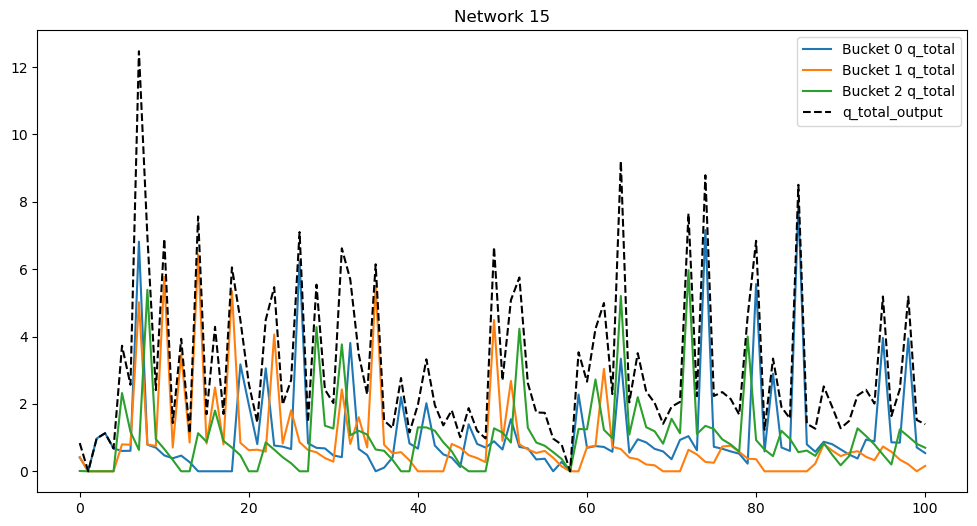

Bucket: 0
Total mean: 0.92
Total max: 8.58
Bucket: 1
Total mean: 1.07
Total max: 8.31
Bucket: 2
Total mean: 0.88
Total max: 9.61


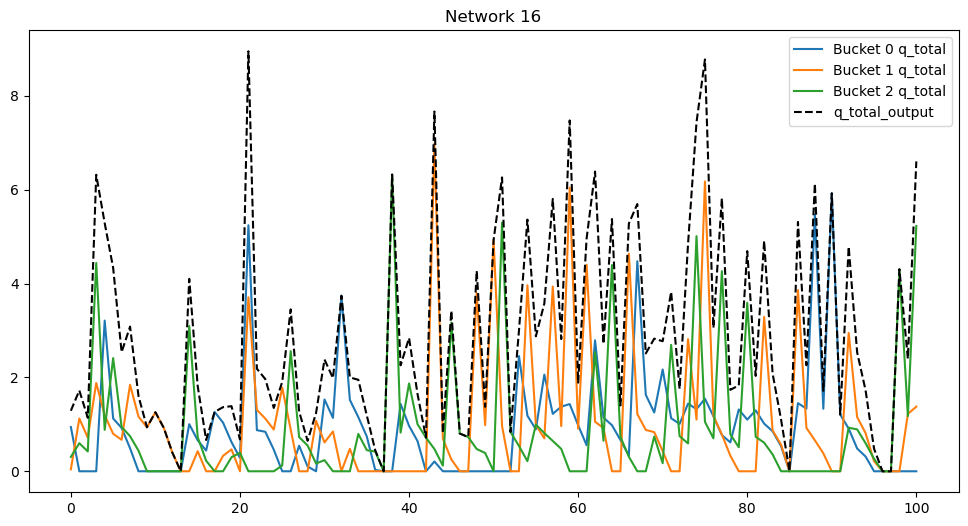

Bucket: 0
Total mean: 1.04
Total max: 8.79
Bucket: 1
Total mean: 1.09
Total max: 7.93
Bucket: 2
Total mean: 1.26
Total max: 8.34


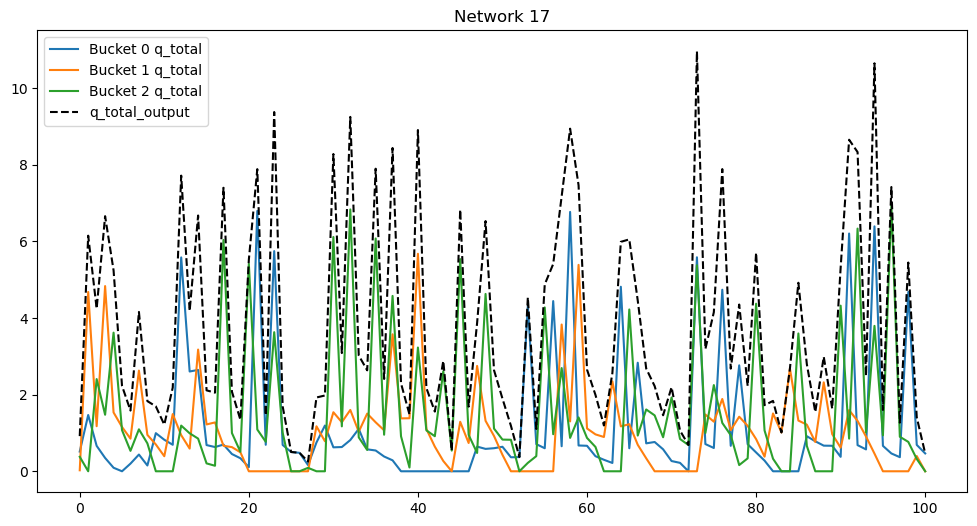

Bucket: 0
Total mean: 1.14
Total max: 9.77
Bucket: 1
Total mean: 0.9
Total max: 6.82
Bucket: 2
Total mean: 0.98
Total max: 9.92


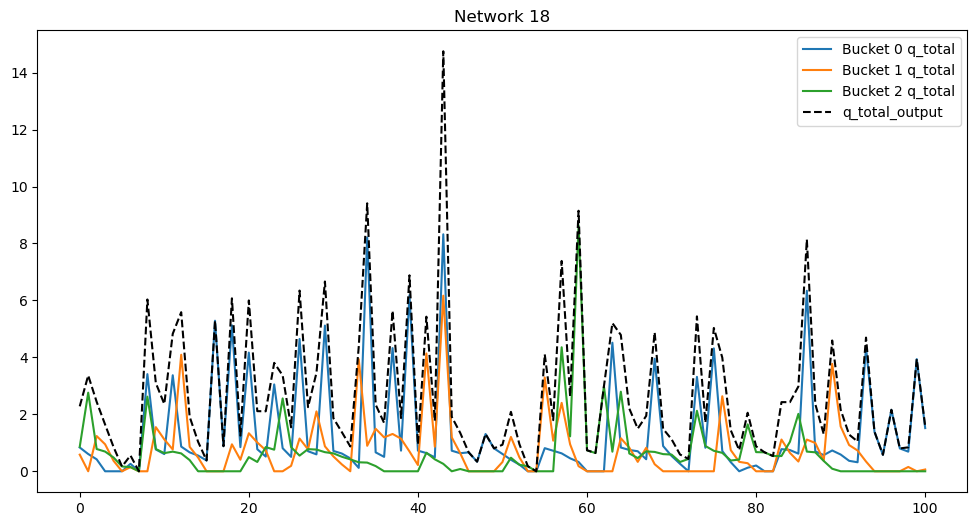

Bucket: 0
Total mean: 0.99
Total max: 7.94
Bucket: 1
Total mean: 1.15
Total max: 8.8
Bucket: 2
Total mean: 0.99
Total max: 8.43


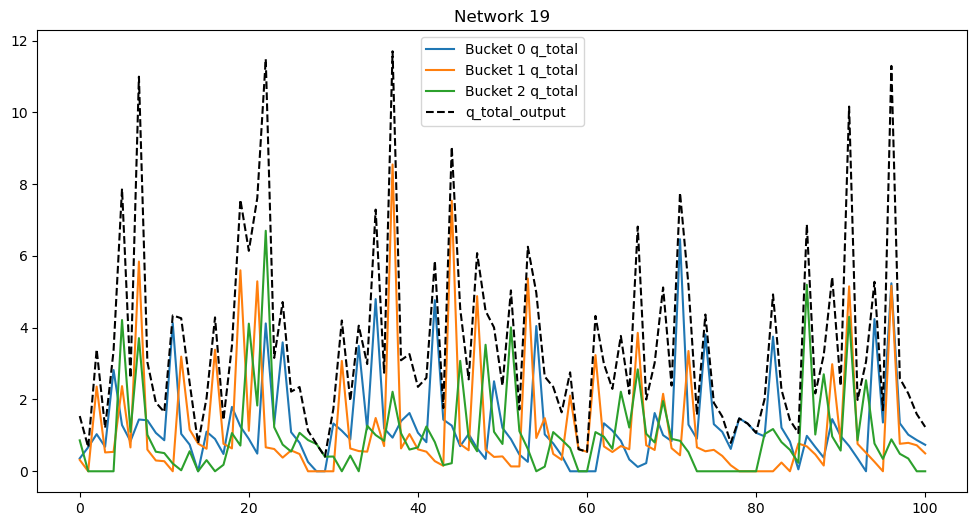

Bucket: 0
Total mean: 1.11
Total max: 8.94
Bucket: 1
Total mean: 1.19
Total max: 8.97
Bucket: 2
Total mean: 1.08
Total max: 8.75


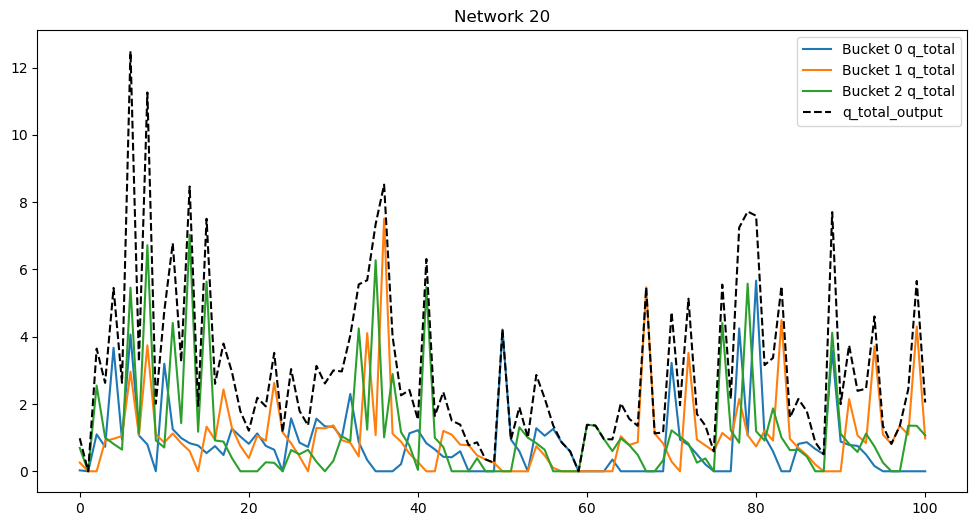

Bucket: 0
Total mean: 1.03
Total max: 9.24
Bucket: 1
Total mean: 1.02
Total max: 8.21
Bucket: 2
Total mean: 1.07
Total max: 8.93


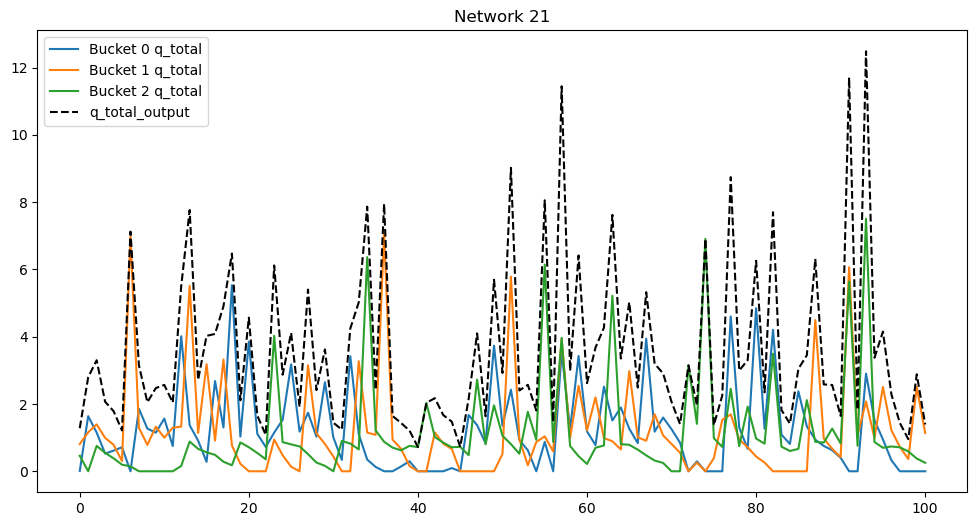

In [40]:
countN = 0
for inetwork in basin_networks_val:
    countN += 1
    viz_network(inetwork)
    if countN == 10:
        break

# 2. Deep learning model
This section sets up our deep learning model and training procedure.

### 2.1 Defining the neural network model
This is the part of the notebook where we will be using the previous simulations to learn from the generated data and subsequently make predictions. Here, we leverage the simulations to extract valuable insights and apply them in our learning and prediction processes.


Here we define a class called LSTM1, which is a PyTorch module for a single-layer Long Short-Term Memory (LSTM) network. 

**Brief explanation**
- The input to the module is a tensor x of shape (batch_size, seq_length, input_size), which represents a sequence of batch_size samples, each of length seq_length, with input_size features at each time step. 
- The LSTM layer is defined using the nn.LSTM class, with input_size as the size of the input layer, hidden_size as the size of the hidden state, and batch_first=True indicating that the first dimension of the input tensor is the batch size. 
- The output of the LSTM layer is passed through a ReLU activation function, and then to a fully connected layer (nn.Linear) with num_classes output units. 
- The forward method takes the input tensor x as an argument, along with an optional tuple init_states representing the initial hidden and internal states of the LSTM layer, and returns the output tensor prediction. 
- If init_states is not provided, it is initialized as a tensor of zeros with shape (batch_size, hidden_size).

In [41]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, batch_size, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length 
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc_1 =  nn.Linear(hidden_size, num_classes) #fully connected 1
   
    def forward(self, x, init_states=None):

        if init_states is None:
            h_t = Variable(torch.zeros(batch_size, self.hidden_size)) # hidden state
            c_t = Variable(torch.zeros(batch_size, self.hidden_size)) # internal state
        else:
            h_t, c_t = init_states
           
        out, _ = self.lstm(x)
        out = self.relu(out)
        prediction = self.fc_1(out) # Dense, fully connected layer
        
        return prediction

### 2.2 Defining a procedure for model validation
Here we verify that our model is working the way we expect. We would especially want to check model validation when changing hyperparameters.

We define a function that validates and tests the LSTM model, as well as checks the water balance of the system. 

**Brief explanation**
- We use the pre-defined LSTM model to make predictions on the validation data. 
- The output of this model is then used to compute two different metrics, the Nash-Sutcliffe Efficiency (NSE) for the spigot_out and mass_overflow columns of the dataframe.
- We plot the actual spigot_out and mass_overflow values against their corresponding LSTM predictions. 
- We check the water balance of the system by summing up the input, evapotranspiration, mass_overflow, spigot_out, and the last recorded water level in the dataframe, and compare this to the total mass out of or left in the system. 
- We print out the percent mass residual as a measure of how well the system is balanced.

In [42]:
def check_validation_period(lstm, np_val_seq_X, inetwork, n_plot=100):

    def __make_prediction(df):
        lstm_output_val = lstm(torch.Tensor(np_val_seq_X[inetwork][ibuc]).to(device=device))
        val_spigot_prediction = []
        val_overflow_prediction = []
        for i in range(lstm_output_val.shape[0]):
            val_spigot_prediction.append((lstm_output_val[i,-1,1].cpu().detach().numpy() * \
                                np.std(df['q_spigot'])) + np.mean(df['q_spigot']))

            val_overflow_prediction.append((lstm_output_val[i,-1,0].cpu().detach().numpy() * \
                                np.std(df['q_overflow'])) + np.mean(df['q_overflow']))
        return val_spigot_prediction, val_overflow_prediction

    '''
    def __compute_nse(df, val_spigot_prediction, val_overflow_prediction):
        spigot_out = df['q_spigot']
        spigot_mean = np.mean(spigot_out)
        spigot_pred_variance = 0
        spigot_obs_variance = 0

        overflow_out = df['q_overflow']
        overflow_mean = np.mean(overflow_out)
        overflow_pred_variance = 0
        overflow_obs_variance = 0

        for i, pred_spigot in enumerate(val_spigot_prediction):
            t = i + seq_length - 1
            spigot_pred_variance += np.power((pred_spigot - spigot_out.values[t]), 2)
            spigot_obs_variance += np.power((spigot_mean - spigot_out.values[t]), 2)

        for i, pred_overflow in enumerate(val_overflow_prediction):
            t = i + seq_length - 1
            overflow_pred_variance += np.power((pred_overflow - overflow_out.values[t]), 2)
            overflow_obs_variance += np.power((overflow_mean - overflow_out.values[t]), 2)

        spigot_nse = 1 - (spigot_pred_variance / spigot_obs_variance)
        overflow_nse = 1 - (overflow_pred_variance / overflow_obs_variance)

        return spigot_nse, overflow_nse
    '''
    def __compute_metrics(df, val_spigot_prediction, val_overflow_prediction):
        spigot_out = df['q_spigot']
        spigot_mean = np.mean(spigot_out)
        spigot_pred_variance = 0
        spigot_obs_variance = 0
        spigot_abs_diff = 0

        overflow_out = df['q_overflow']
        overflow_mean = np.mean(overflow_out)
        overflow_pred_variance = 0
        overflow_obs_variance = 0
        overflow_abs_diff = 0

        for i, pred_spigot in enumerate(val_spigot_prediction):
            t = i + seq_length - 1
            spigot_pred_variance += np.power((pred_spigot - spigot_out.values[t]), 2)
            spigot_obs_variance += np.power((spigot_mean - spigot_out.values[t]), 2)
            spigot_abs_diff += np.abs(pred_spigot - spigot_out.values[t])

        for i, pred_overflow in enumerate(val_overflow_prediction):
            t = i + seq_length - 1
            overflow_pred_variance += np.power((pred_overflow - overflow_out.values[t]), 2)
            overflow_obs_variance += np.power((overflow_mean - overflow_out.values[t]), 2)            
            overflow_abs_diff += np.abs(pred_overflow - overflow_out.values[t])

        spigot_nse = 1 - (spigot_pred_variance / spigot_obs_variance)
        overflow_nse = 1 - (overflow_pred_variance / overflow_obs_variance)
        
        spigot_rmse = np.sqrt(spigot_pred_variance / len(val_spigot_prediction))
        overflow_rmse = np.sqrt(overflow_pred_variance / len(val_overflow_prediction))
        
        spigot_mae = spigot_abs_diff / len(val_spigot_prediction)
        overflow_mae = overflow_abs_diff / len(val_overflow_prediction)

        return spigot_nse, overflow_nse, spigot_rmse, overflow_rmse, spigot_mae, overflow_mae

    
    def __compute_mass_balance(df):
        mass_in = df.sum()['precip']
        mass_out = df.sum()['et'] + df.sum()['q_overflow'] + df.sum()['q_spigot'] + df.loc[num_records - 1, 'h_bucket']
        return mass_in, mass_out

    print("Network", inetwork)
    for ibuc in range(n_buckets_per_network):
        df = retrieve_data(inetwork, ibuc, basin_network_dictionary)
        val_spigot_prediction, val_overflow_prediction = __make_prediction(df)
        #spigot_nse, overflow_nse = __compute_nse(df, val_spigot_prediction, val_overflow_prediction)
        spigot_nse, overflow_nse, spigot_rmse, overflow_rmse, spigot_mae, overflow_mae = __compute_metrics(df, val_spigot_prediction, val_overflow_prediction)

        print("Bucket", ibuc)
        print("NSE Spigot: ", spigot_nse)
        print("NSE Overflow: ", overflow_nse)
        print("RMSE Spigot: ", spigot_rmse)
        print("RMSE Overflow: ", overflow_rmse)
        print("MAE Spigot: ", spigot_mae)
        print("MAE Overflow: ", overflow_mae)

        mass_in, mass_out = __compute_mass_balance(df)

        print("Mass into the system: ", mass_in)
        print("Mass out or left over:", mass_out)
        print("percent mass residual: {:.0%}".format((mass_in - mass_out) / mass_in))

        fig = plt.figure(figsize=(12, 3))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        #ax1.plot(df.loc[val_start + seq_length - 1:val_start + n_plot + seq_length - 1, 'q_spigot'].values, label="Spigot out")
        ax1.plot(df['q_spigot'].values[:n_plot], label="Spigot out")
        ax1.plot(val_spigot_prediction[:n_plot], label="LSTM spigot out")
        ax1.legend()
        #ax2.plot(df.loc[val_start + seq_length - 1:val_start + n_plot + seq_length - 1, 'q_overflow'].values, label="Overflow")
        ax2.plot(df['q_overflow'].values[:n_plot], label="Overflow")
        ax2.plot(val_overflow_prediction[:n_plot], label="LSTM Overflow")
        ax2.legend()
        plt.show()
        plt.close()



### 2.3 Instantiating the neural network model (LSTM)

Using the hyperparameters from Section 1.2, we define a specific instance of the LSTM model and set up the LSTM

In [43]:
torch.manual_seed(1)
lstm = LSTM1(num_classes=n_output,  
             input_size=n_input,    
             hidden_size=hidden_state_size, 
             num_layers=num_layers, 
             batch_size=batch_size, 
             seq_length=seq_length).to(device=device)

### 2.4 Setting up the data to feed into the model

We will set up data for:
- training, to calculate the loss which is backpropogated through the model
- validation, where we get predictions from the trained model and see if the performance is up to our standards
- testing, the data we will utimately use to report the LSTM performance. 

Note: testing is the last thing we would do, if we go back to validation after this step, we would be P-hacking.

**Fitting a scaler to the training set to transform all the data**

Here we fit a scaler to the training set, allowing for the transformation of input and output variables to a normalized and standardized scale, which helps in training the model and maintaining consistency across different datasets. This normalization step ensures that the data is suitable for training our LSTM model. 

In [44]:
def fit_scaler():
    # Adjust scaler for input
    frames = [basin_network_dictionary['buckets'][inetwork][ibuc].loc[:, input_vars] for inetwork in basin_networks_train for ibuc in range(n_buckets_per_network)]
    df_in = pd.concat(frames)    
    scaler_in = StandardScaler()
    scaler_train_in = scaler_in.fit_transform(df_in)

    # Adjust scaler for output
    scaler_out = []
    for ibuc in range(n_buckets_per_network):
        frames = [basin_network_dictionary['buckets'][inetwork][ibuc].loc[:, output_vars[ibuc]] for inetwork in basin_networks_train]
        df_out = pd.concat(frames)
        scaler = StandardScaler()
        scaler_train_out = scaler.fit_transform(df_out)
        scaler_out.append(scaler)

    return scaler_in, scaler_out


In [45]:
scaler_in, scaler_out = fit_scaler()

**Function to create data loader for each data split**

We prepare and organize the data for training. We create data loaders that handle batch processing and shuffling of the data. We also add some preprocessing steps such as scaling the input and output variables. The data loaders and numpy arrays are used for feeding the data into the neural network during the training process.

In [46]:
def make_data_loader(basin_networks_list):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}

    # Recorremos las redes en la lista proporcionada
    for inetwork in basin_networks_list:
        np_seq_X[inetwork] = {}
        np_seq_y[inetwork] = {}
        for ibuc in range(n_buckets_per_network):
            # Aquí, asumimos que cada dataframe en la red cubre el mismo rango de tiempo
            df = basin_network_dictionary['buckets'][inetwork][ibuc]
            # Transformamos todo el dataframe, en lugar de un rango de tiempo específico
            scaler_in_i = scaler_in.transform(df.loc[:, input_vars])
            scaler_out_i = scaler_out[ibuc].transform(df.loc[:, output_vars[ibuc]])

            np_seq_X_ibuc = np.zeros((scaler_in_i.shape[0] - seq_length, seq_length, n_input))
            np_seq_y_ibuc = np.zeros((scaler_out_i.shape[0] - seq_length, seq_length, n_output))
            
            for i in range(0, scaler_in_i.shape[0] - seq_length):
                t = i+seq_length
                np_seq_X_ibuc[i, :, :] = scaler_in_i[i:t,:]
                np_seq_y_ibuc[i, :, :] = scaler_out_i[i:t,:]

            ds = torch.utils.data.TensorDataset(torch.Tensor(np_seq_X_ibuc), 
                                                torch.Tensor(np_seq_y_ibuc))
            
            loader[inetwork* n_buckets_per_network + ibuc] = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
            np_seq_X[inetwork][ibuc] = np_seq_X_ibuc
            np_seq_y[inetwork][ibuc] = np_seq_y_ibuc
    
    return loader, np_seq_X, np_seq_y


We use the function above and parameters defined in the notebook environment to generate the training, validation, test data loaders

In [47]:

train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(basin_networks_train)
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(basin_networks_val)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(basin_networks_test)


### 2.5 Training the model: Learning the general response of the example dynamic ''hydrologic" system
Now is the time to train the model! Everything above was done in preparation for this step.

Here we define a function to train the LSTM neural network model with the nn.MSELoss() loss function and using the Adam optimizer and hyperparameters defined above.

**Brief explanation**:
- The training is done for a specified number of epochs.
- For each epoch, the training data is divided into buckets. 
- For each bucket, the data is loaded using a PyTorch DataLoader and passed through the LSTM model. 
- The output is then compared with the target values using the custom loss function. 
- The gradients are calculated and the optimizer is used to update the weights of the model. 
- We use the tqdm library to show the progress of the training. 
- Finally, we estimate the average RMSE for each epoch. 

In [48]:
def train_model(lstm, train_loader, basin_networks_train):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[0])
    epoch_bar = tqdm(range(num_epochs), desc="Training", position=0, total=num_epochs)

    # Create a dictionary to store the results
    results = {}

    for epoch in epoch_bar:
        for inetwork in basin_networks_train:
            # Initialize results for each network at the beginning
            if inetwork not in results:
                results[inetwork] = {"loss": [], "RMSE": []}

            batch_bar = tqdm(enumerate(train_loader[inetwork]),
                             desc="Network: {}, Epoch: {}".format(str(inetwork), str(epoch)),
                             position=1, total=len(train_loader[inetwork]), leave=False, disable=True)

            for i, (data, targets) in batch_bar:

                optimizer.zero_grad()

                optimizer = optim.Adam(lstm.parameters(), lr=learning_rate[epoch])

                data = data.to(device=device)
                targets = targets.to(device=device)

                # Forward
                lstm_output = lstm(data)
                loss = criterion(lstm_output, targets)

                #backward
                optimizer.zero_grad()
                loss.backward()

                # gradient descent or adam step
                optimizer.step()

                batch_bar.set_postfix(loss=loss.to(device).item(),
                                      RMSE="{:.2f}".format(loss ** (1 / 2)),
                                      epoch=epoch)
                batch_bar.update()

            with torch.no_grad():
                rmse_list = []
                for i, (data_, targets_) in enumerate(train_loader[inetwork]):
                    data_ = data_.to(device=device)
                    targets_ = targets_.to(device=device)
                    lstm_output_ = lstm(data_)
                    MSE_ = criterion(lstm_output_, targets_)
                    rmse_list.append(MSE_ ** (1 / 2))

            meanrmse = np.mean(np.array(torch.Tensor(rmse_list)))
            epoch_bar.set_postfix(loss=loss.cpu().item(),
                                  RMSE="{:.2f}".format(meanrmse),
                                  epoch=epoch)

            results[inetwork]["loss"].append(loss.cpu().item())
            results[inetwork]["RMSE"].append(meanrmse)

            batch_bar.update()

        #clear_output()

    return lstm, results


Run the train model functon by prescribing the buckets and data to use for training and the intantiated LSTM

In [49]:

lstm, results = train_model(lstm, train_loader, basin_networks_train)


Training:   0%|          | 0/15 [00:00<?, ?it/s]

### 2.5 Visualizing the learning curves

 We plot the loss and root mean square error (RMSE) metrics for each epoch to check if the model fitting has converged

In [50]:
def viz_learning_curve(results):
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for inetwork in basin_networks_train:
        num_epochs_executed = len(results[inetwork]['loss'])
        ax1.plot(range(num_epochs_executed), results[inetwork]['loss'])
        ax2.plot(range(num_epochs_executed), results[inetwork]['RMSE'])
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('RMSE')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    plt.suptitle("Learning curves for each network") 
    plt.show()


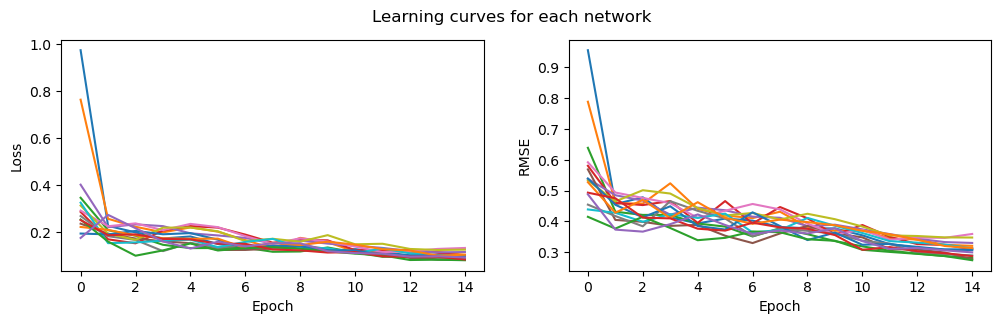

In [51]:
viz_learning_curve(results)

### 2.6 Checking that the model works on the validation data
Now that we have a trained model, we can see how it works on our validation split.

Network 15
Bucket 0
NSE Spigot:  0.7041878766967902
NSE Overflow:  0.8986273884325566
RMSE Spigot:  0.17997386264236714
RMSE Overflow:  0.41437359086634923
MAE Spigot:  0.14888644714910634
MAE Overflow:  0.16762867094966866
Mass into the system:  2283.105215992628
Mass out or left over: 2284.962115044916
percent mass residual: -0%


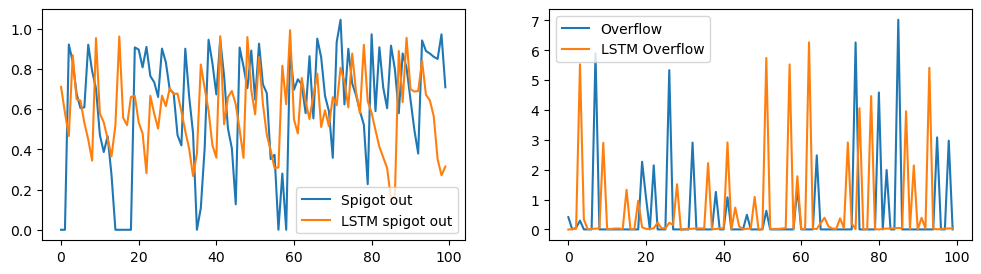

Bucket 1
NSE Spigot:  0.806927660666422
NSE Overflow:  0.8906049631483218
RMSE Spigot:  0.1395745624657425
RMSE Overflow:  0.4066582927926561
MAE Spigot:  0.11436849996330233
MAE Overflow:  0.1595844228149606
Mass into the system:  2303.347755682685
Mass out or left over: 2293.132645167295
percent mass residual: 0%


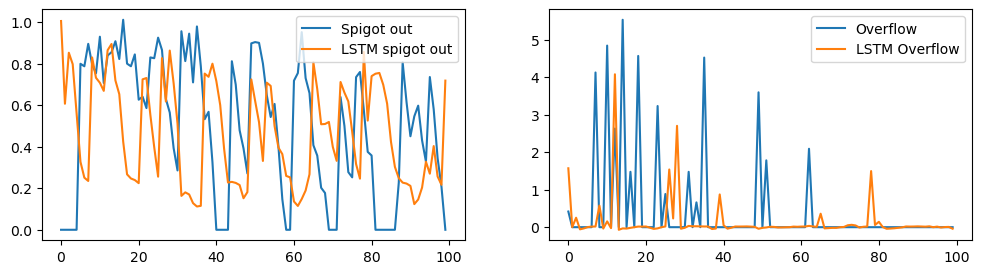

Bucket 2
NSE Spigot:  0.8612468700896021
NSE Overflow:  0.8897881297195639
RMSE Spigot:  0.17862025203657791
RMSE Overflow:  0.31679077599296995
MAE Spigot:  0.14460443797974692
MAE Overflow:  0.1404614591148562
Mass into the system:  2342.0435250914693
Mass out or left over: 2319.710563564217
percent mass residual: 1%


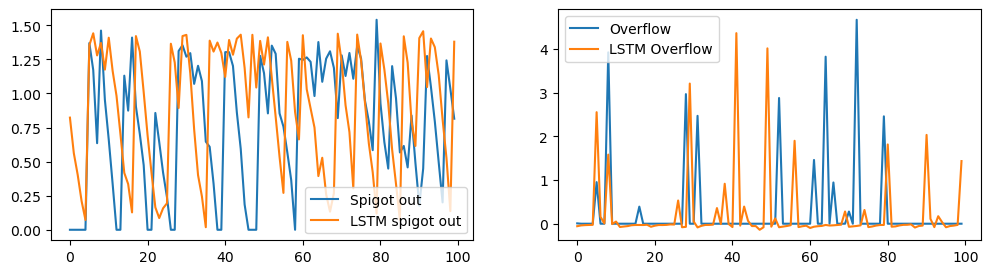

Network 16
Bucket 0
NSE Spigot:  0.8233957642404269
NSE Overflow:  0.8690179033616221
RMSE Spigot:  0.2388183589532933
RMSE Overflow:  0.29575287496312763
MAE Spigot:  0.18134799260225348
MAE Overflow:  0.12771401182598316
Mass into the system:  1992.7213681692263
Mass out or left over: 2008.9086393833427
percent mass residual: -1%


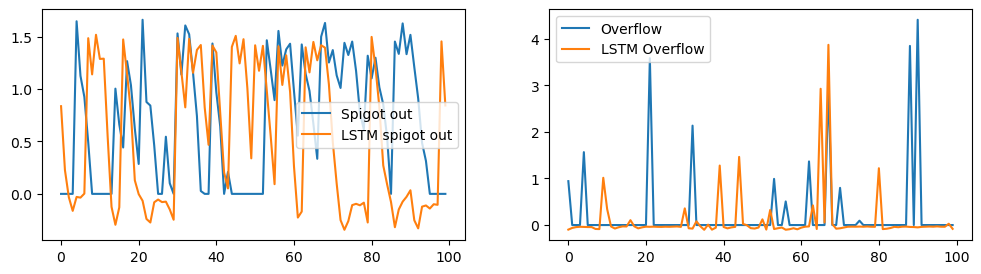

Bucket 1
NSE Spigot:  0.8364044657999516
NSE Overflow:  0.8575609004191084
RMSE Spigot:  0.2021233875080897
RMSE Overflow:  0.4743989259513118
MAE Spigot:  0.14682994966186969
MAE Overflow:  0.20811836568748932
Mass into the system:  2427.250535785755
Mass out or left over: 2383.4004826481246
percent mass residual: 2%


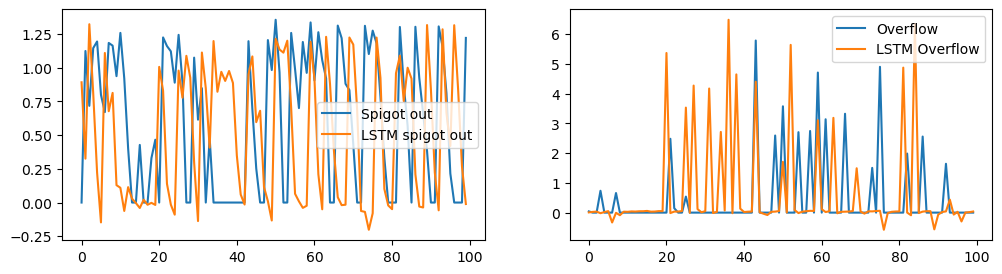

Bucket 2
NSE Spigot:  0.6816849894759414
NSE Overflow:  0.916195651717195
RMSE Spigot:  0.22176589744156636
RMSE Overflow:  0.34233654305012934
MAE Spigot:  0.1786979113558593
MAE Overflow:  0.12637011609114937
Mass into the system:  2003.4547353251135
Mass out or left over: 1980.2455489215354
percent mass residual: 1%


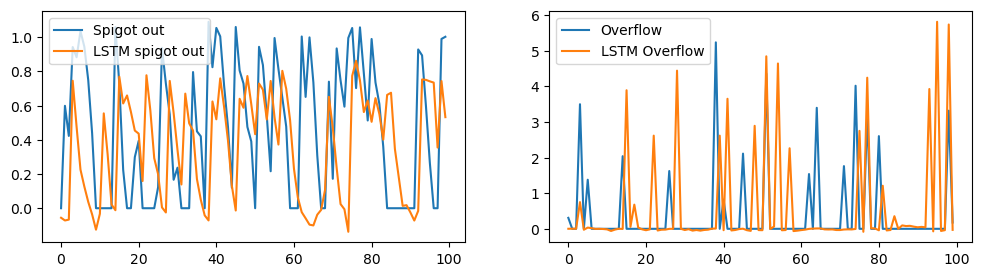

Network 17
Bucket 0
NSE Spigot:  0.716404738318098
NSE Overflow:  0.8416524980049825
RMSE Spigot:  0.16179699695296337
RMSE Overflow:  0.5475043132763624
MAE Spigot:  0.1365782010958737
MAE Overflow:  0.23319398630158109
Mass into the system:  2319.6758181520518
Mass out or left over: 2285.5155095176274
percent mass residual: 1%


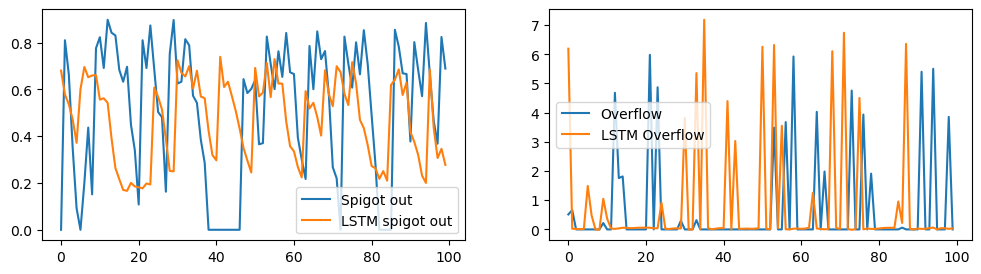

Bucket 1
NSE Spigot:  0.8654857320022344
NSE Overflow:  0.8708082523722382
RMSE Spigot:  0.2140581905075864
RMSE Overflow:  0.35322029058090354
MAE Spigot:  0.16263466170220747
MAE Overflow:  0.1533012900335345
Mass into the system:  2372.1503778179
Mass out or left over: 2394.3774010726856
percent mass residual: -1%


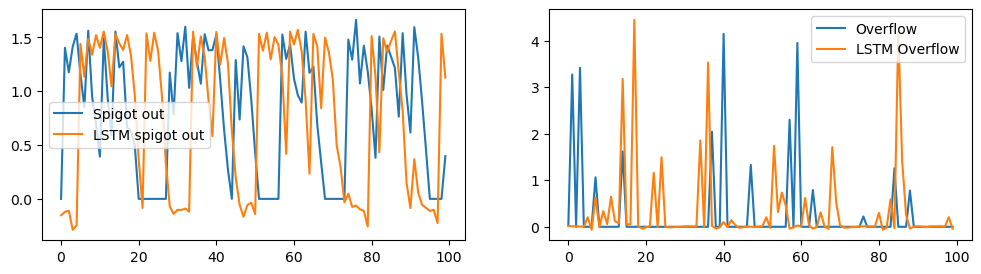

Bucket 2
NSE Spigot:  0.8254610837785041
NSE Overflow:  0.4098801037713967
RMSE Spigot:  0.218709260723438
RMSE Overflow:  1.0152539233070035
MAE Spigot:  0.16598825050067967
MAE Overflow:  0.5122940068038836
Mass into the system:  2745.622833226687
Mass out or left over: 2698.585755336186
percent mass residual: 2%


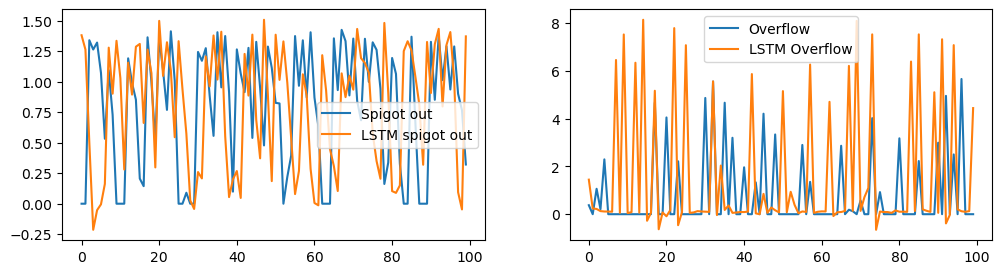

Network 18
Bucket 0
NSE Spigot:  0.7091246832360996
NSE Overflow:  0.8906350865989652
RMSE Spigot:  0.16471315433501563
RMSE Overflow:  0.46593046040751457
MAE Spigot:  0.1419797450845074
MAE Overflow:  0.26405102536707437
Mass into the system:  2522.1610475203333
Mass out or left over: 2516.744968060294
percent mass residual: 0%


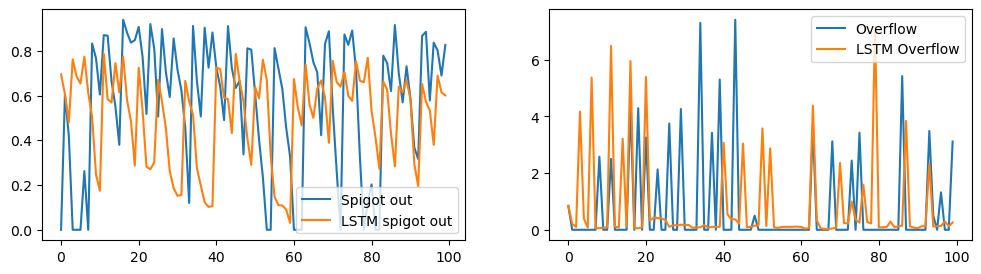

Bucket 1
NSE Spigot:  0.8701474926229792
NSE Overflow:  0.861139154664773
RMSE Spigot:  0.19447437449029448
RMSE Overflow:  0.33863909843856727
MAE Spigot:  0.1470234548892691
MAE Overflow:  0.13439861854006738
Mass into the system:  2059.145335213744
Mass out or left over: 2039.5370336089293
percent mass residual: 1%


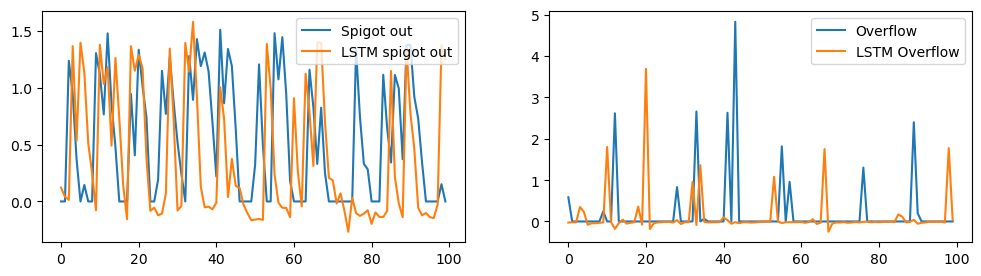

Bucket 2
NSE Spigot:  0.8067004324750654
NSE Overflow:  0.8951544198218322
RMSE Spigot:  0.13696925309335015
RMSE Overflow:  0.41296067895283906
MAE Spigot:  0.111987483451866
MAE Overflow:  0.1636341148430373
Mass into the system:  2149.5502934972988
Mass out or left over: 2165.3266350838785
percent mass residual: -1%


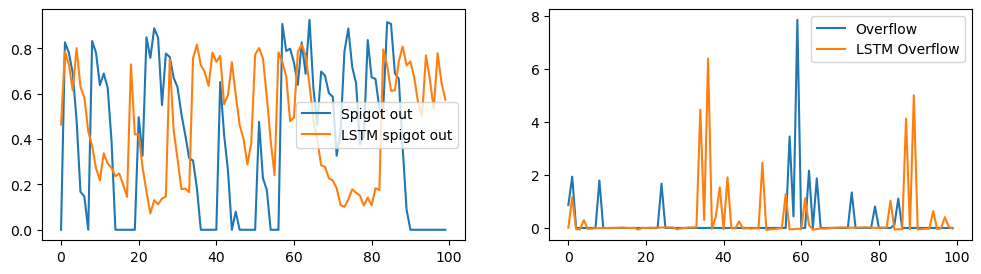

Network 19
Bucket 0
NSE Spigot:  0.8839862747130325
NSE Overflow:  0.8610516729946195
RMSE Spigot:  0.19609164517081737
RMSE Overflow:  0.3318900304250179
MAE Spigot:  0.15058583676977905
MAE Overflow:  0.13930465974558914
Mass into the system:  2198.8379754727125
Mass out or left over: 2183.3751588837185
percent mass residual: 1%


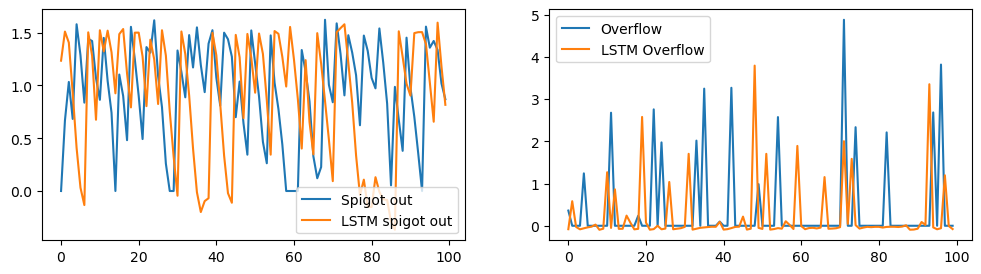

Bucket 1
NSE Spigot:  0.6876482288241277
NSE Overflow:  0.7493875757653641
RMSE Spigot:  0.16541996322592517
RMSE Overflow:  0.7250362996706394
MAE Spigot:  0.13715191455795994
MAE Overflow:  0.3689774883030075
Mass into the system:  2532.8313187640106
Mass out or left over: 2508.837389576493
percent mass residual: 1%


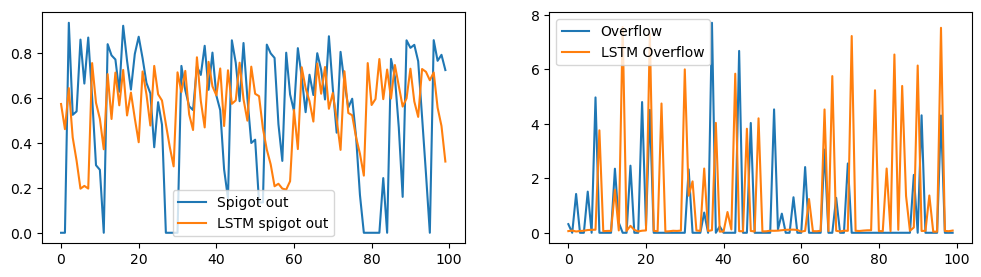

Bucket 2
NSE Spigot:  0.7819188200020202
NSE Overflow:  0.8877485061896973
RMSE Spigot:  0.2204170740550057
RMSE Overflow:  0.3636512272406249
MAE Spigot:  0.1697055379117864
MAE Overflow:  0.14271043708996992
Mass into the system:  2215.513903808095
Mass out or left over: 2190.257347856277
percent mass residual: 1%


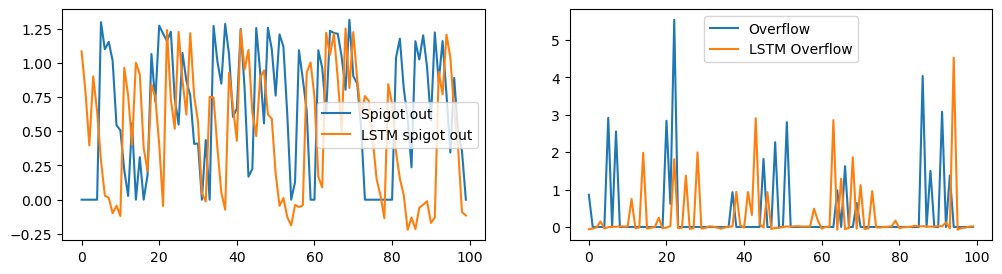

Network 20
Bucket 0
NSE Spigot:  0.8551836912016784
NSE Overflow:  0.8976492846681472
RMSE Spigot:  0.17957417687031316
RMSE Overflow:  0.34177674893069093
MAE Spigot:  0.14149432425280756
MAE Overflow:  0.13306425684903664
Mass into the system:  2455.052886128043
Mass out or left over: 2410.0022280613775
percent mass residual: 2%


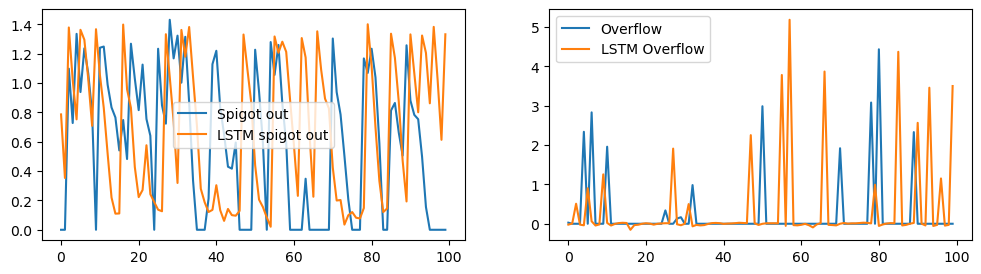

Bucket 1
NSE Spigot:  0.8635705745618443
NSE Overflow:  0.8898290349587681
RMSE Spigot:  0.17728262671036651
RMSE Overflow:  0.38083974979378266
MAE Spigot:  0.1437169119162294
MAE Overflow:  0.14702722807121266
Mass into the system:  2604.4181888784374
Mass out or left over: 2573.4280031435796
percent mass residual: 1%


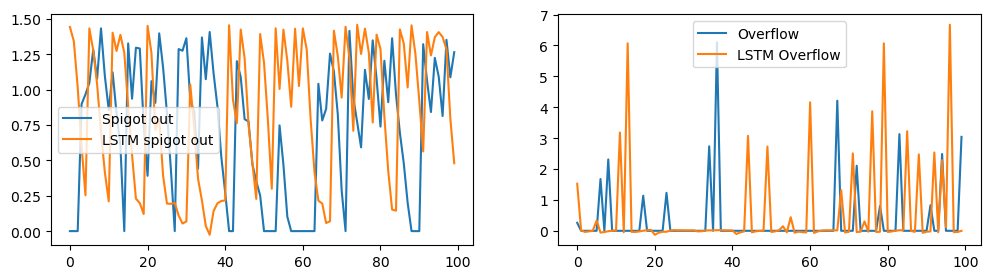

Bucket 2
NSE Spigot:  0.8524056828403846
NSE Overflow:  0.8680585184315796
RMSE Spigot:  0.1965301383328623
RMSE Overflow:  0.39140402843667405
MAE Spigot:  0.1488032625468976
MAE Overflow:  0.20311532482270966
Mass into the system:  2331.1010926348895
Mass out or left over: 2335.095786701474
percent mass residual: -0%


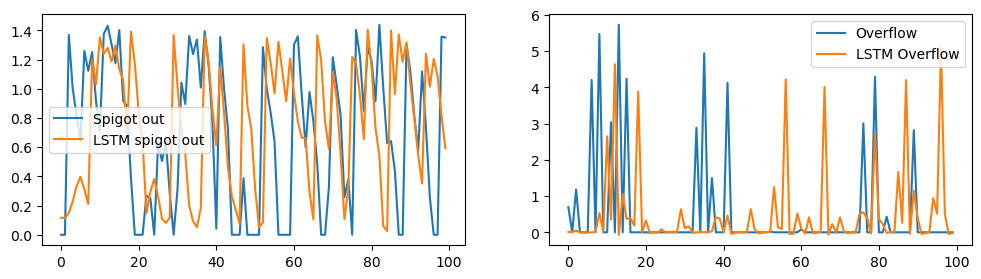

Network 21
Bucket 0
NSE Spigot:  0.8277594362410517
NSE Overflow:  0.8867041748578195
RMSE Spigot:  0.27005201189562156
RMSE Overflow:  0.30654788453324866
MAE Spigot:  0.21432208943525546
MAE Overflow:  0.13634883460843955
Mass into the system:  2273.2611584775345
Mass out or left over: 2231.688494668226
percent mass residual: 2%


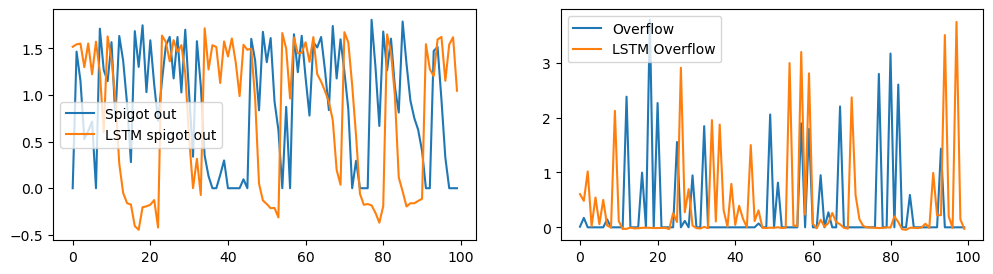

Bucket 1
NSE Spigot:  0.8947763499897228
NSE Overflow:  0.9169107679311004
RMSE Spigot:  0.16871165487089065
RMSE Overflow:  0.3116005232610126
MAE Spigot:  0.12291220749380938
MAE Overflow:  0.11636500011645964
Mass into the system:  2235.2823645081485
Mass out or left over: 2230.1314292595634
percent mass residual: 0%


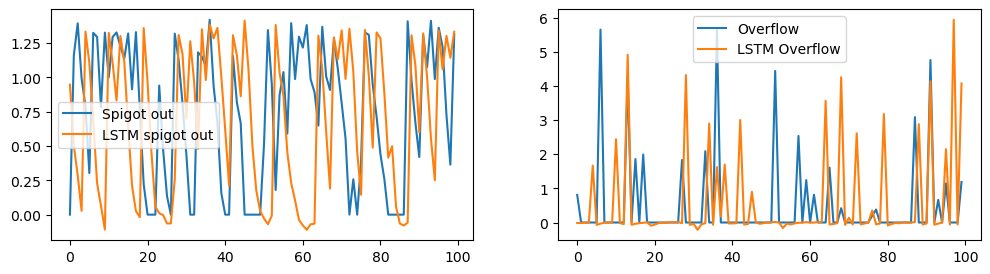

Bucket 2
NSE Spigot:  0.5853672241978354
NSE Overflow:  0.9085637521036632
RMSE Spigot:  0.21175765997448426
RMSE Overflow:  0.36900777242728255
MAE Spigot:  0.15759347131844628
MAE Overflow:  0.1412416213744586
Mass into the system:  2344.5439605995
Mass out or left over: 2307.698247600569
percent mass residual: 2%


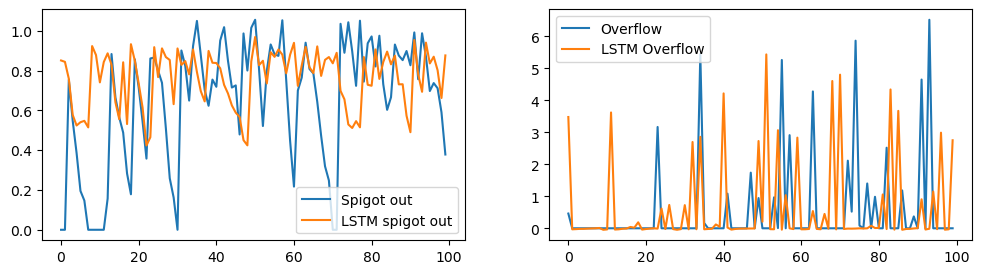

In [52]:
for inetwork in basin_networks_val:
    check_validation_period(lstm, np_val_seq_X, inetwork)

In [ ]:
print("End")

# 3. Experimentation

Now that we have a general leaky bucket model setup and training/validation framework, we can use it to experiment with variations on the bucket characteristics and modelling setup.


Try changing some bucket configuration attributes here to modify the "ground truth" data, for example:
- to simulate a more "flashy" system, reduce the probability of heavy precipitation and increase the magnitude
- to simulate smaller buckets, reduce the size of the bucket attributes
- or to add more noise, increase noise from 0.1 to different values 

Try changing some aspects of the modelling setup, for example:
- increase or decrease the number of training buckets
- increase or decrease the timeseries length

In [34]:
rain_probability_range = {"None": [0.6, 0.7], "Light": [0.5, 0.8], "Heavy": [0.05, 0.1]}
rain_depth_range = {"Light": [0, 2], "Heavy": [6, 14]}

bucket_attributes_range = {"A_bucket": [1.0, 2.0],
                           "A_spigot": [0.1, 0.2],
                           "H_bucket": [5.0, 6.0],
                           "H_spigot": [1.0, 3.0],
                           "K_infiltration": [1e-7, 1e-9],
                           "ET_parameter": [7, 9]
                          }

noise = {"pet": 0.1, "et": 0.1, "q": 0.1, "head": 0.1} 

In [35]:
n_buckets_split = {"train": 25, "val": 5,"test": 1}
time_splits = {"train": 2000, "val": 1000,"test": 500}
num_records = time_splits["train"] + time_splits["val"] + time_splits["test"] + seq_length * 3
n_buckets = n_buckets_split["train"] + n_buckets_split["val"] + n_buckets_split["test"]

[[buckets_for_training, train_start, train_end],
[buckets_for_val, val_start, val_end],
[buckets_for_test, test_start, test_end]]= split_parameters()

Re-generate forcings and 'ground truth' data for buckets

Bucket: 26
Overflow mean: 1.52
Overflow max: 14.94


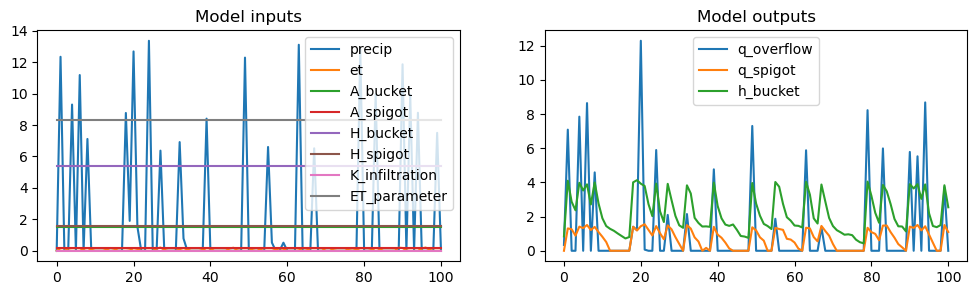

Bucket: 27
Overflow mean: 1.5
Overflow max: 15.14


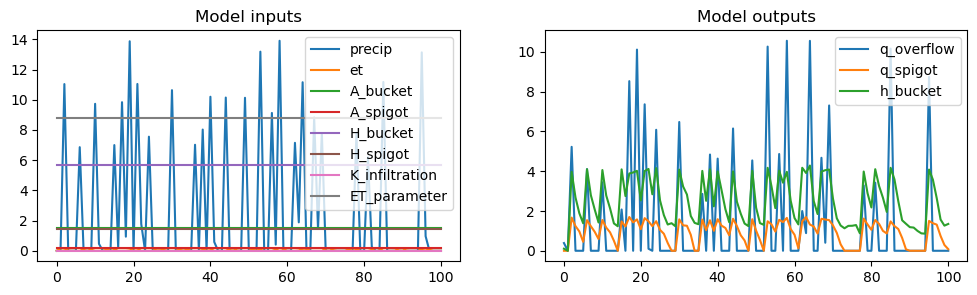

Bucket: 28
Overflow mean: 1.65
Overflow max: 15.78


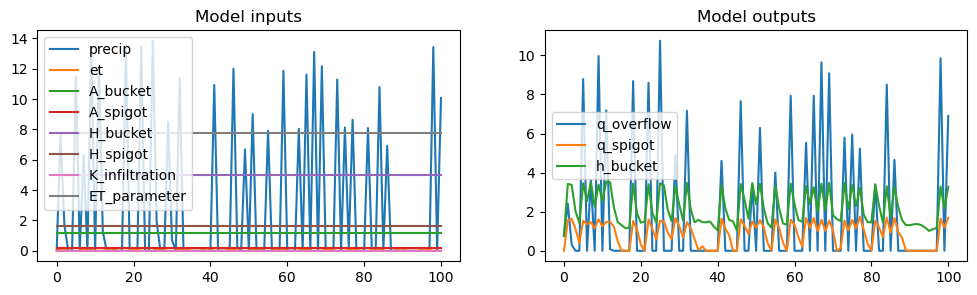

Bucket: 29
Overflow mean: 1.8
Overflow max: 16.61


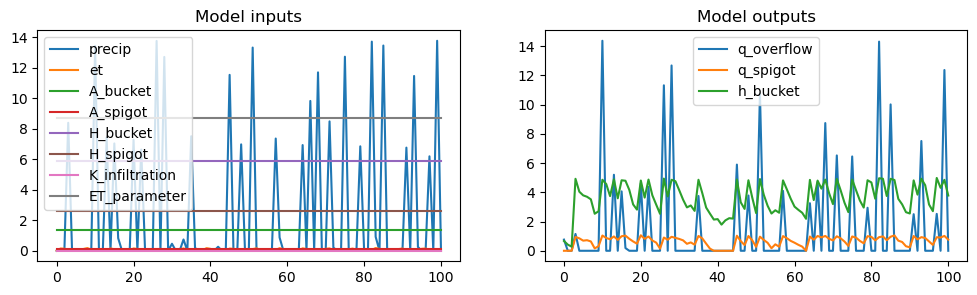

Bucket: 30
Overflow mean: 1.68
Overflow max: 15.92


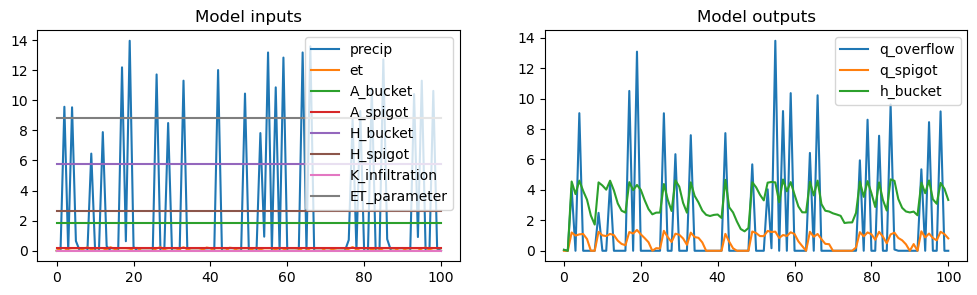

In [36]:
buckets, h_water_level, mass_overflow = setup_buckets(n_buckets)

in_list = {}
for ibuc in range(n_buckets):
    bucket_rain_params = pick_rain_params()
    in_list[ibuc] = [0]
    for i in range(1, num_records):
        in_list[ibuc].append(random_rain(in_list[ibuc][i-1], bucket_rain_params))

bucket_dictionary = {}
for ibuc in range(n_buckets):
    bucket_dictionary[ibuc] = run_bucket_simulation(ibuc)
    
for ibuc in buckets_for_val:
    viz_simulation(ibuc)

Re-create new data loaders

In [37]:
scaler_in, scaler_out = fit_scaler()
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader(train_start, train_end, buckets_for_training)
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(val_start, val_end, buckets_for_val)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(test_start, test_end, buckets_for_test)

Reinitializing the LSTM model, the training process is performed with the updated dataset.

In [38]:
lstm = LSTM1(num_classes=n_output,  
             input_size=n_input,    
             hidden_size=hidden_state_size, 
             num_layers=num_layers, 
             batch_size=batch_size, 
             seq_length=seq_length).to(device=device)

lstm, results = train_model(lstm, train_loader, buckets_for_training)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Visualize the learning curve based on the training results.

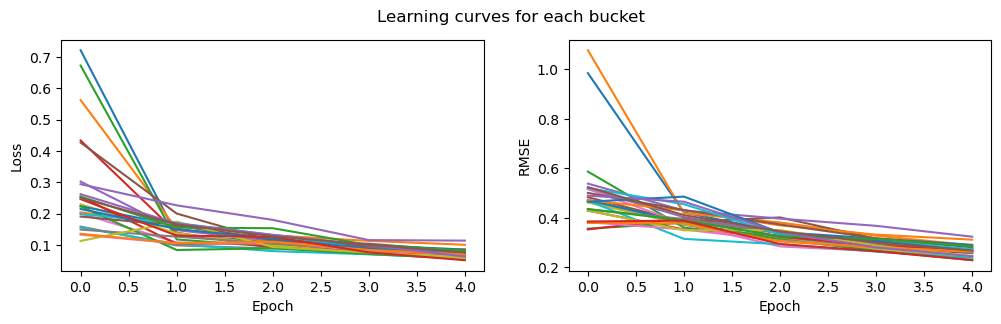

Spigot NSE 0.8874
Overflow NSE 0.9479
Mass into the system:  8565.679580014077
Mass out or left over: 8535.362960839517
percent mass resudual: 0%


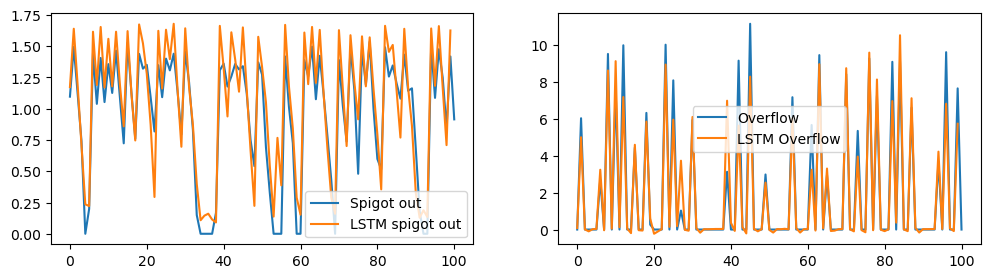

Spigot NSE 0.8233
Overflow NSE 0.9244
Mass into the system:  8800.807452119376
Mass out or left over: 8747.0248797366
percent mass resudual: 1%


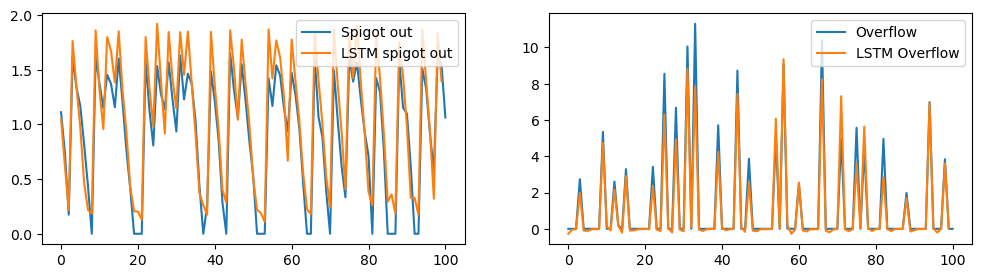

Spigot NSE 0.8159
Overflow NSE 0.9382
Mass into the system:  8970.904628098666
Mass out or left over: 8988.667881737338
percent mass resudual: -0%


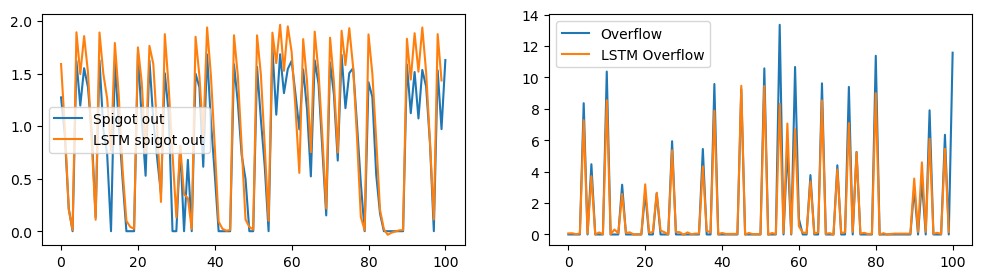

Spigot NSE 0.7734
Overflow NSE 0.9458
Mass into the system:  8966.946556832958
Mass out or left over: 8910.583318789942
percent mass resudual: 1%


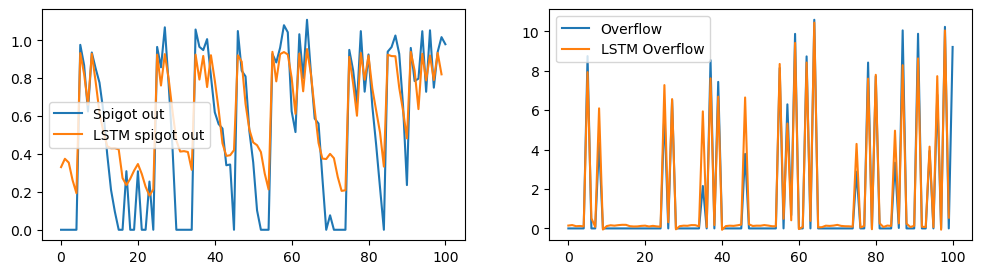

Spigot NSE 0.8815
Overflow NSE 0.9482
Mass into the system:  8727.820537197558
Mass out or left over: 8679.378448393127
percent mass resudual: 1%


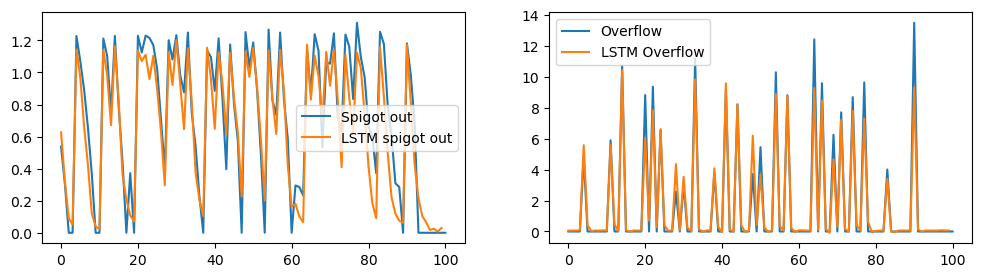

In [39]:
viz_learning_curve(results)

for ibuc in buckets_for_val:
    check_validation_period(lstm, np_val_seq_X, ibuc)